### Install following packages

- yfinance
- tensorflow
- keras

If they don't show up, add conda-forge in the channel.

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from keras import backend as K

import tensorflow as tf


In [2]:
%pip install yfinance
%pip install matplotlib
%pip install keras
%pip install tensorflow
%pip install -U scikit-learn

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     --------------------------- ------------ 2.1/3.0 MB 11.8 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 10.8 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 12.4 MB/s eta 0:00:00
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15618 sha256=ad3b24850a9620a7e42f976f5f22ca943426b417496788992c50cb5d095e1cc0
  Stored in directory: c:\user

  DEPRECATION: Building 'multitasking' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'multitasking'. Discussion can be found at https://github.com/pypa/pip/issues/6334


Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 8.4 MB/s eta 0:00:00

   ------------------------ --------------- 3/5 [absl-py]
   -------------------------------- ------- 4/5 [keras]
   -------------------------------- ------- 4/5 [keras]
   -------------------------------- ------- 4/5 [keras]
   -------------------------------- ------- 4/5 [keras]
   -------------------------------- ------- 4/5 [keras]
   -------------------------------- ------- 4/5 [keras]
   -------------------------------- ------- 4/5 [keras]
   -------------------------------- ------- 4/5 [keras]
   -------------------------------- ------- 4/5 [keras]
   -------------------------------- ------- 4/5 [keras]
   -------------------------------- ------- 4/5 [keras]
   -------------------------------- ------- 4/5 [keras]
   -------------------------------- ------- 4/5 [keras]
  

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.2 which is incompatible.


In [4]:
# loss function
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


C:\RTemp\ipykernel_38216\819042326.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AAPL', start='2010-01-01', end='2020-01-01')
[*********************100%***********************]  1 of 1 completed


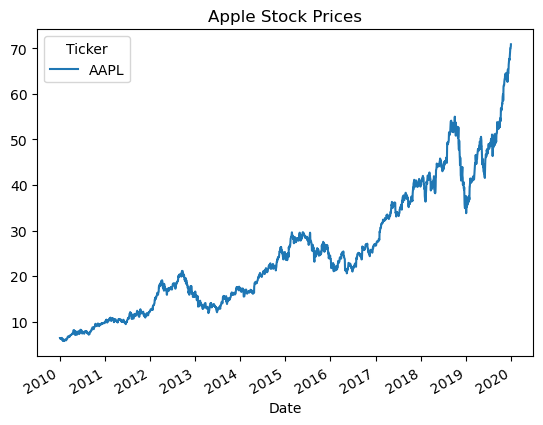

In [5]:
# Download stock data for Apple from Yahoo Finance for the specified date range.
data = yf.download('AAPL', start='2010-01-01', end='2020-01-01')
data = data[['Close']]  # We will predict the closing price
data['Close'].plot(title='Apple Stock Prices')
plt.show()

In [6]:
data.values.size

2516

In [7]:
# Normalize the data
# Normalize the data to a range of 0 to 1 for better performance of neural networks.

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values)


# Function to create datasets for training and testing.
# This function segments the data into features (X) and target (Y) with a specified number of time steps.
# Create data in 60 timesteps and convert into array

def create_dataset(dataset, time_step=60):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

X, y = create_dataset(scaled_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

# Reshape input to be [samples, time steps, features] which is required for LSTM models.
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [8]:
# Build the LSTM model,
# Building the LSTM model with two LSTM layers and two Dense layers.

# Initializes a linear stack of layers in the model. In a Sequential model, each layer has exact one input tensor and one output tensor.
model = Sequential()

# This line adds a Long Short-Term Memory (LSTM) layer with 50 units (neurons).
model.add(
    LSTM(50, return_sequences=True, input_shape=(60, 1))
)  # First LSTM layer with 50 units, returns sequences for stacking LSTM layers.

# TODO add two additional LSTM layers ***

# Unlike the first LSTM layer, this parameter setting tells the layer to output only the last step of the sequence.
# This is useful when the next layer is a dense layer that expects a single vector input rather than a sequence.
model.add(
    LSTM(50, return_sequences=False)
)  # Second LSTM layer, does not return sequences to flatten output for the dense layer.

# TODO add Dropout layers ***
# TODO add Dense layer with ReLU as activation function

# This adds a fully connected (dense) layer with 25 neurons.
# Dense layers are standard neural network layers where each input is connected to each output by a learnable weight.
# This layer will interpret the features learned by the LSTM layers, effectively beginning the process of converting the learned sequences into a final prediction.
model.add(Dense(25))  # Dense layer with 25 neurons.

# The final layer in the model is another dense layer, but with just one neuron.
# This is the output layer, and its purpose is to produce a single continuous output value that predicts the next day's closing price.
model.add(Dense(1))  # Output layer with 1 neuron to predict the closing price.

# Compile the model,
# TODO change to two different optimizers other than Adam
# Compile the model using Adam optimizer and mean squared error as the loss function.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss="mean_squared_error",
    metrics=["mean_absolute_error", "mean_squared_error", rmse],
)

# Train the model
num_epochs = 10
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=num_epochs,
    batch_size=64,
    verbose=1,
)

# Predicting and inverse transformation to original prices
# Predicting and transforming predictions back to original scale.
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

Epoch 1/10


c:\Users\Peter Chapman\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0061 - mean_absolute_error: 0.0533 - mean_squared_error: 0.0061 - rmse: 0.1726 - val_loss: 0.0025 - val_mean_absolute_error: 0.0440 - val_mean_squared_error: 0.0025 - val_rmse: 0.0759
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.7720e-04 - mean_absolute_error: 0.0125 - mean_squared_error: 2.7720e-04 - rmse: 0.1829 - val_loss: 9.4083e-04 - val_mean_absolute_error: 0.0228 - val_mean_squared_error: 9.4083e-04 - val_rmse: 0.0640
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.3467e-04 - mean_absolute_error: 0.0087 - mean_squared_error: 1.3467e-04 - rmse: 0.1819 - val_loss: 8.9401e-04 - val_mean_absolute_error: 0.0225 - val_mean_squared_error: 8.9401e-04 - val_rmse: 0.0637
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.2723e-04 - mean_absolute_error: 0.0084 - mean_squared_error: 1.2723e-04 - rmse: 0.1832 - val_loss: 8.6335e-04 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 8.6335e-04 - 

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,705 (373.85 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,804 (249.24 KB)

In [10]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'mean_squared_error', 'rmse', 'val_loss', 'val_mean_absolute_error', 'val_mean_squared_error', 'val_rmse'])

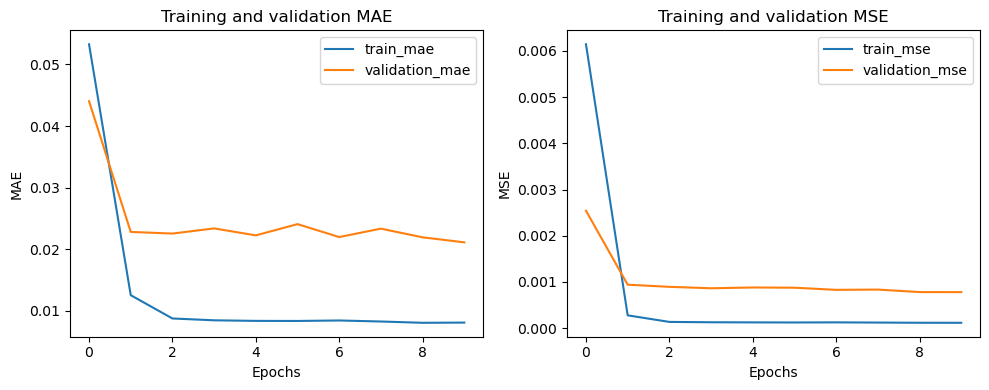

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot training & validation MAE values
ax1.plot(
    range(num_epochs), history.history["mean_absolute_error"], label="train_mae"
)
ax1.plot(
    range(num_epochs),
    history.history["val_mean_absolute_error"],
    label="validation_mae",
)
ax1.set_title("Training and validation MAE")
ax1.set_ylabel("MAE")
ax1.set_xlabel("Epochs")
ax1.legend()

# Plot training & validation MSE values
ax2.plot(
    range(num_epochs), history.history["mean_squared_error"], label="train_mse"
)
ax2.plot(
    range(num_epochs),
    history.history["val_mean_squared_error"],
    label="validation_mse",
)
ax2.set_title("Training and validation MSE")
ax2.set_ylabel("MSE")
ax2.set_xlabel("Epochs")
ax2.legend()

fig.tight_layout()
plt.show()

In [12]:
fig.savefig(f"numEpochs_{num_epochs}-learningRate_{learn_rate}.png")

NameError: name 'learn_rate' is not defined